# Agent
## ReAct (에이전트 구조)
- Act(행동) -> 모델이 판단 후 특정 Tool을 호출
- Observe(관찰) -> 위에서 호출한 Tool 결과를 다시 모델이 받아서 확인
- Reason(판단) -> 모델이 Tool 결과를 보고 다음 스텝을 결정(ex. 다른 Tool을 쓸지 / 바로답을 할지 등)


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [17]:
from langchain.tools import tool
from langchain_openai import ChatOpenAI


@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model='gpt-4.1', temperature=0)

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [18]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content='너는 입력 숫자를 받아 산수 연산을 도와주는 어시스턴트야')

# Node
def assistant(state: MessagesState):
    new_msg = llm_with_tools.invoke([sys_msg] + state['messages'])
    return {'messages': new_msg}

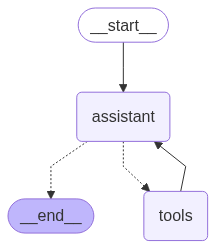

In [19]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# 그래프 빌더
builder = StateGraph(MessagesState)

# 노드 등록
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# 엣지 연결
builder.add_edge(START, 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition  # 'tools' or END 로 가도록 되어있음. END 없음
)
builder.add_edge('tools', 'assistant')  # Loop

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
my_msg = '3에다 4를 더해.'

res = graph.invoke({'messages': [my_msg]})

for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

3에다 4를 더해.
================================== Ai Message ==================================
Tool Calls:
  add (call_tDdHeVifACXbN2Z9IInMckAv)
 Call ID: call_tDdHeVifACXbN2Z9IInMckAv
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3에 4를 더하면 7입니다.


In [23]:
my_msg = '거기다 2를 곱해'

res = graph.invoke({'messages': [my_msg]})

for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

거기다 2를 곱해
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Xorhe6cffNPrG5fWskTy9YkO)
 Call ID: call_Xorhe6cffNPrG5fWskTy9YkO
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

2에 2를 곱하면 4입니다. 

다른 연산이 필요하신가요?


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 추가
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [29]:
# 스레드를 지정
config = {'configurable': {'thread_id': '1'}}

my_msg = '거기에 5를 나눠'

res = graph.invoke({'messages': [my_msg]}, config=config)

for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

3에다 4를 더해
================================== Ai Message ==================================
Tool Calls:
  add (call_TP6VocNRPSFyepL1BLAh4u6w)
 Call ID: call_TP6VocNRPSFyepL1BLAh4u6w
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3에 4를 더하면 7입니다.
================================ Human Message =================================

거기다 2를 곱해
================================== Ai Message ==================================
Tool Calls:
  multiply (call_GXr94JqHlZWeI79YfxICc4Rr)
 Call ID: call_GXr94JqHlZWeI79YfxICc4Rr
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

7에 2를 곱하면 14가 됩니다.
========================

In [ ]:
'https://chatgpt.com/c/68ba296d-12e8-832f-9a32-b4b3eaf4d562'